In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from sklearn.linear_model import RidgeCV, LassoCV

In [279]:
# Загрузка данных
file_path = 'my_data.csv'
data = pd.read_csv(file_path)

# Описание данных
data

date_without_country = data[['Life_expectancy', 'Adult_Mortality', 'Hepatitis_B', 'BMI', 'GDP', 'Population', 'Schooling']]


In [280]:
data_description = data.describe()
data_description

,Life_expectancy,Adult_Mortality,Hepatitis_B,BMI,GDP,Population,Schooling
count,114.000000,114.000000,114.000000,114.000000,114.000000,1.140000e+02,114.000000
mean,71.206140,157.517544,81.070175,42.157018,6290.799397,1.305232e+07,12.900000
std,7.775333,95.168433,24.583511,21.022630,10641.104330,3.197673e+07,2.763286
min,52.400000,1.000000,6.000000,2.500000,33.681223,8.381000e+03,5.400000
25%,66.025000,79.000000,77.250000,23.800000,702.333884,2.841920e+05,10.800000
50%,72.500000,145.500000,91.500000,49.250000,2231.867706,2.691076e+06,12.750000
75%,76.175000,214.000000,96.000000,61.675000,6454.061607,1.237155e+07,15.000000
max,85.000000,484.000000,99.000000,77.600000,56554.387600,2.581621e+08,20.400000


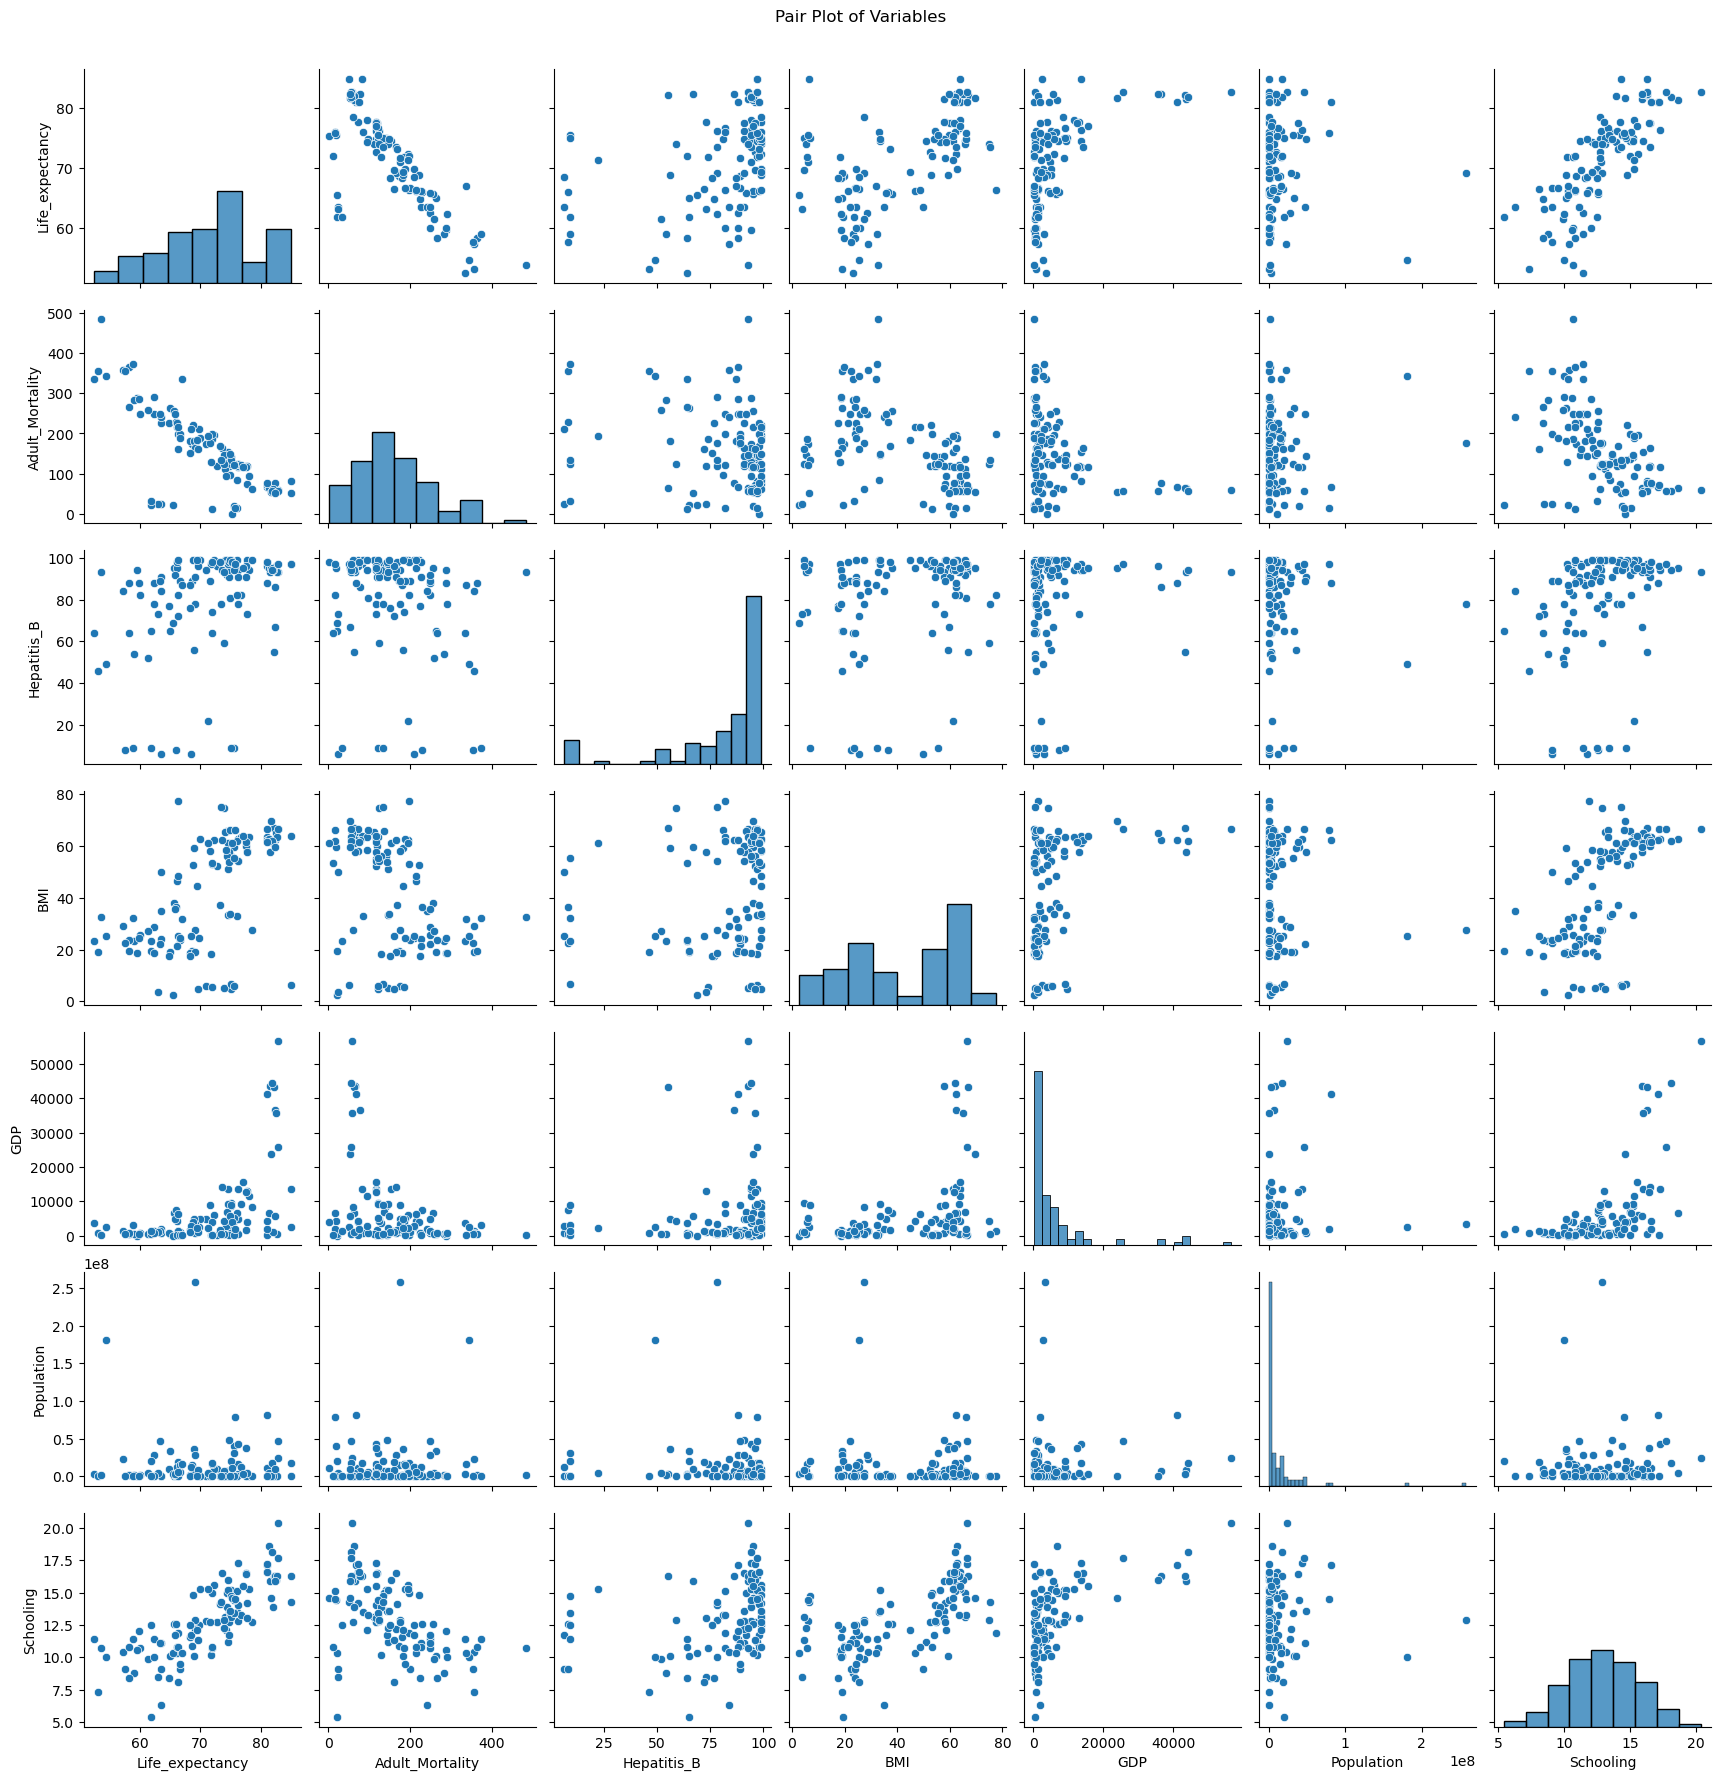

In [281]:
# Визуализация данных
# Парные графики зависимых и независимых переменных
sns.pairplot(date_without_country)
plt.suptitle("Pair Plot of Variables", y=1.02)
plt.show()

In [282]:
# Корреляционный анализ
correlation_matrix = date_without_country.corr()
correlation_matrix

,Life_expectancy,Adult_Mortality,Hepatitis_B,BMI,GDP,Population,Schooling
Life_expectancy,1.000000,-0.781751,0.378777,0.586588,0.502794,-0.053805,0.794569
Adult_Mortality,-0.781751,1.000000,-0.191829,-0.421893,-0.335099,0.040140,-0.509000
Hepatitis_B,0.378777,-0.191829,1.000000,0.199602,0.120065,-0.057014,0.307586
BMI,0.586588,-0.421893,0.199602,1.000000,0.385081,-0.026226,0.636167
GDP,0.502794,-0.335099,0.120065,0.385081,1.000000,0.066281,0.575654
Population,-0.053805,0.040140,-0.057014,-0.026226,0.066281,1.000000,0.026298
Schooling,0.794569,-0.509000,0.307586,0.636167,0.575654,0.026298,1.000000


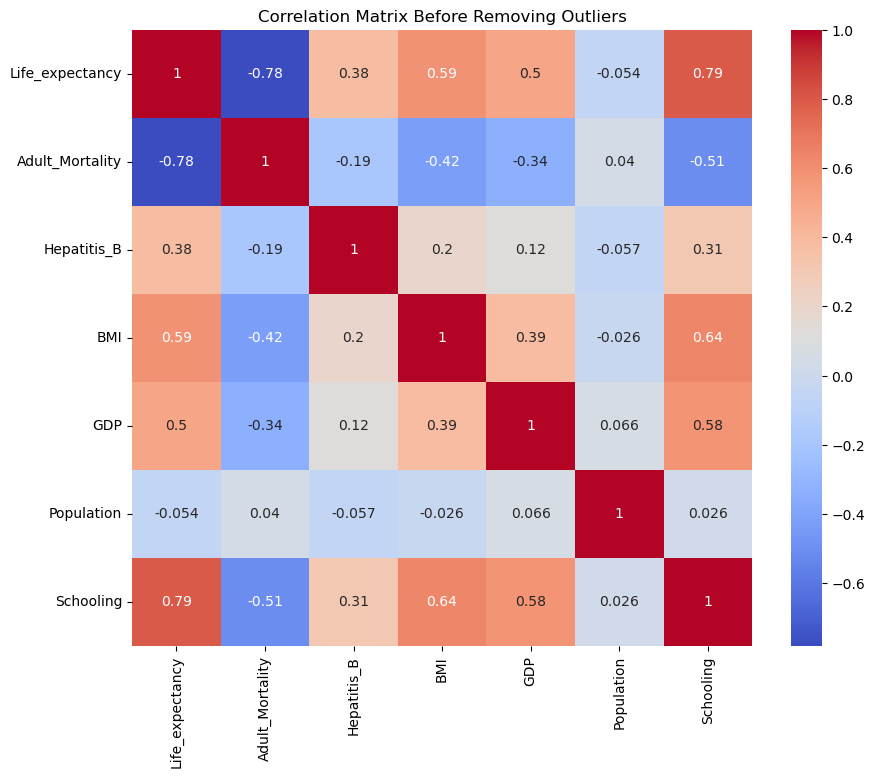

In [283]:
# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Before Removing Outliers")
plt.show()

In [284]:
data = data[['Country', 'Life_expectancy', 'Adult_Mortality', 'Hepatitis_B', 'BMI', 'GDP', 'Schooling']]


def remove_outliers(df, column_name):
    def find_iqr(x):
        return np.subtract(np.percentile(x, 75), np.percentile(x, 25))
    Q1, Q3 = np.percentile(df[column_name], [25, 75])
    IQR = find_iqr(df[column_name])
    df_clean = df[(df[column_name] < (Q3+1.5*IQR)) & (df[column_name] > (Q1- 1.5*IQR))]
    return df_clean

clear_data = remove_outliers(remove_outliers(remove_outliers(remove_outliers(remove_outliers(data,'Adult_Mortality' ),'Hepatitis_B' ),'BMI' ),'GDP' ),'Schooling' )
data_without_country = clear_data[['Life_expectancy', 'Adult_Mortality', 'Hepatitis_B', 'BMI', 'GDP', 'Schooling']]


In [285]:
data = clear_data

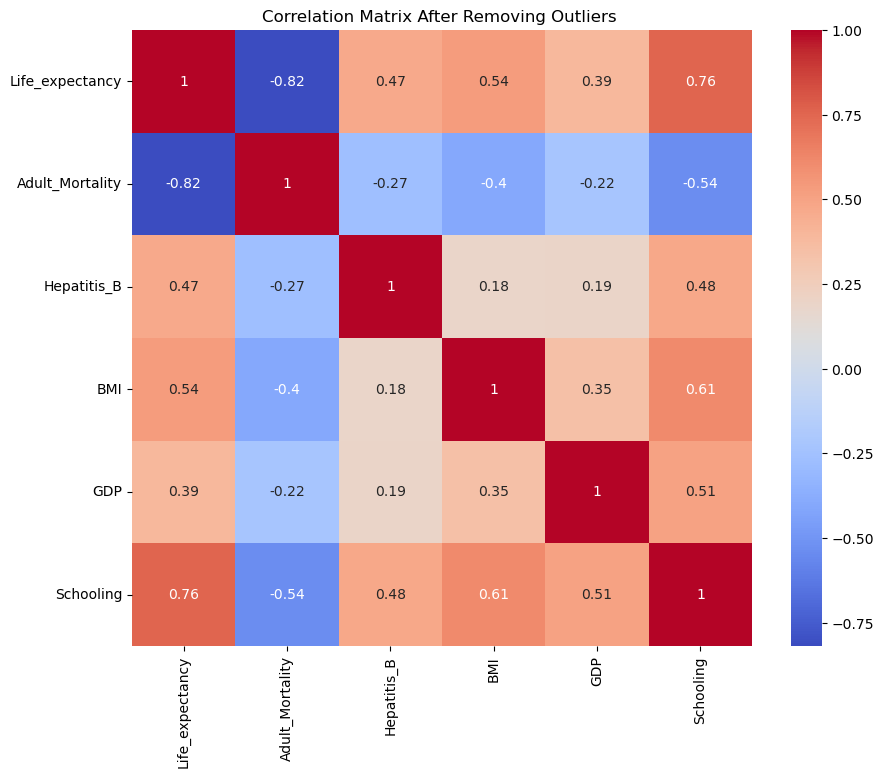

In [286]:

correlation_matrix = data_without_country.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix After Removing Outliers ")
plt.show()


In [287]:
#Проверка на мультиколлинеарность
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant  

X = add_constant(data_without_country)  
ds = pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(ds)

const              513.586928
Life_expectancy      5.849347
Adult_Mortality      3.346406
Hepatitis_B          1.452810
BMI                  1.693378
GDP                  1.384981
Schooling            3.313544
dtype: float64


In [288]:
# X = np.array(data[['Adult_Mortality', 'Hepatitis_B', 'BMI', 'GDP', 'Schooling']])
# w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X), X)), np.transpose(X)), np.array(data['Life_expectancy']))
# w

In [289]:
# Построение модели линейной регрессии
model = ols('Life_expectancy ~ Adult_Mortality + Hepatitis_B + BMI + GDP + Schooling', data=data).fit()
print(model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.819   
Dependent Variable: Life_expectancy  AIC:                467.4753
Date:               2023-11-30 22:39 BIC:                482.6060
No. Observations:   92               Log-Likelihood:     -227.74 
Df Model:           5                F-statistic:        83.41   
Df Residuals:       86               Prob (F-statistic): 1.74e-31
R-squared:          0.829            Scale:              8.8497  
-----------------------------------------------------------------
                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        59.1458   2.9540  20.0223 0.0000 53.2734 65.0181
Adult_Mortality  -0.0475   0.0044 -10.7119 0.0000 -0.0564 -0.0387
Hepatitis_B       0.0787   0.0286   2.7531 0.0072  0.0219  0.1356
BMI               0.0221   0.0191   1.1583 0.2500 -0.0158  0.0599
GDP               0.0001   

In [290]:
model2 = ols('Life_expectancy ~ Adult_Mortality + Hepatitis_B + Schooling', data=data).fit()
print(model2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.818   
Dependent Variable: Life_expectancy  AIC:                466.2031
Date:               2023-11-30 22:39 BIC:                476.2903
No. Observations:   92               Log-Likelihood:     -229.10 
Df Model:           3                F-statistic:        137.2   
Df Residuals:       88               Prob (F-statistic): 4.47e-33
R-squared:          0.824            Scale:              8.9088  
-----------------------------------------------------------------
                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept        58.4424   2.8951  20.1869 0.0000 52.6890 64.1957
Adult_Mortality  -0.0478   0.0044 -10.8468 0.0000 -0.0566 -0.0391
Hepatitis_B       0.0714   0.0283   2.5256 0.0133  0.0152  0.1276
Schooling         1.1011   0.1655   6.6545 0.0000  0.7723  1.4299
---------------------------

In [291]:
#Переход к логарифму
log_data = pd.concat([np.log(data['Life_expectancy'] + 1e-6), data[['Adult_Mortality', 'Hepatitis_B', 'BMI', 'GDP', 'Schooling']]], axis=1, join="inner")
log_model = ols('Life_expectancy ~ Adult_Mortality + Hepatitis_B + BMI + GDP + Schooling', data=log_data).fit()
print(log_model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.818    
Dependent Variable: Life_expectancy  AIC:                -311.0941
Date:               2023-11-30 22:39 BIC:                -295.9634
No. Observations:   92               Log-Likelihood:     161.55   
Df Model:           5                F-statistic:        82.95    
Df Residuals:       86               Prob (F-statistic): 2.12e-31 
R-squared:          0.828            Scale:              0.0018690
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          4.0885   0.0429  95.2386 0.0000  4.0032  4.1739
Adult_Mortality   -0.0007   0.0001 -10.9209 0.0000 -0.0008 -0.0006
Hepatitis_B        0.0014   0.0004   3.2497 0.0016  0.0005  0.0022
BMI                0.0004   0.0003   1.3394 0.1840 -0.0002  0.0009
GDP          

In [292]:
log_model2 = ols('Life_expectancy ~ Adult_Mortality + Hepatitis_B + Schooling', data=log_data).fit()
print(log_model2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.816    
Dependent Variable: Life_expectancy  AIC:                -311.6946
Date:               2023-11-30 22:39 BIC:                -301.6075
No. Observations:   92               Log-Likelihood:     159.85   
Df Model:           3                F-statistic:        135.3    
Df Residuals:       88               Prob (F-statistic): 7.54e-33 
R-squared:          0.822            Scale:              0.0018953
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          4.0776   0.0422  96.5629 0.0000  3.9936  4.1615
Adult_Mortality   -0.0007   0.0001 -11.0332 0.0000 -0.0008 -0.0006
Hepatitis_B        0.0012   0.0004   2.9827 0.0037  0.0004  0.0020
Schooling          0.0147   0.0024   6.0799 0.0000  0.0099  0.0195
-------------

In [293]:
# Тесты на гетероскедастичность
# Тест Бройша-Пагана 
labels = ['Statistic', 'p-value', 'F-Statistic', 'F-Test p-value']
bp_test = het_breuschpagan(model2.resid, model2.model.exog)
print('Breusch-Pagan test statistics for model2:\n', dict(zip(labels, bp_test)))
bp_test = het_breuschpagan(log_model2.resid, log_model2.model.exog)
print('Breusch-Pagan test statistics for log_model2:\n', dict(zip(labels, bp_test)))



Breusch-Pagan test statistics for model2:
 {'Statistic': 14.987488280182966, 'p-value': 0.001827372367975924, 'F-Statistic': 5.708591756512032, 'F-Test p-value': 0.0012847889088059138}
Breusch-Pagan test statistics for log_model2:
 {'Statistic': 14.409447953854752, 'p-value': 0.0023976292030918364, 'F-Statistic': 5.447533608581126, 'F-Test p-value': 0.0017547067772082368}


In [294]:
# Тест Уайта
white_test = het_white(log_model2.resid, log_model2.model.exog)
print('White test statistics:\n', dict(zip(labels, white_test)))
#print('chi-square critical: ', scipy.stats.chi2.ppf(0.95, 4))

#Поправка Уайта
robust_model = log_model2.get_robustcov_results()
robust_white_test = het_white(robust_model.resid, robust_model.model.exog)
print(robust_model.summary2())
print('White test statistics after Waite_s amendment:\n', dict(zip(labels, robust_white_test)))
bp_test = het_breuschpagan(robust_model.resid, robust_model.model.exog)
print('Breusch-Pagan test statistics:\n', dict(zip(labels, bp_test)))

White test statistics:
 {'Statistic': 46.18064772501648, 'p-value': 5.574480589341659e-07, 'F-Statistic': 9.182954182340781, 'F-Test p-value': 1.723690734742465e-09}
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.816    
Dependent Variable: Life_expectancy  AIC:                -311.6946
Date:               2023-11-30 22:39 BIC:                -301.6075
No. Observations:   92               Log-Likelihood:     159.85   
Df Model:           3                F-statistic:        114.8    
Df Residuals:       88               Prob (F-statistic): 2.59e-30 
R-squared:          0.822            Scale:              0.0018953
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           4.0776   0.0644 63.3415 0.0000  3.9496  4.2055
Adult_Mortality    -0.0007   0.0001 -6.5073 0.00

In [295]:
#Попробуем применить логарифмическое преобразование также к зависимым переменным
log_data2 =  data[['Life_expectancy', 'Adult_Mortality', 'Hepatitis_B', 'BMI', 'Schooling']]
log_data2[['Adult_Mortality', 'Hepatitis_B', 'Schooling']] = np.log(log_data2[['Adult_Mortality', 'Hepatitis_B', 'Schooling']] + 1e-6)
log_model3 = ols('Life_expectancy ~ Adult_Mortality + Hepatitis_B + Schooling', data=log_data2).fit()
print("\nLog Transformed Model Summary:\n", log_model3.summary2())
log3_white_test = het_white(log_model3.resid, log_model3.model.exog)
print('White test statistics for log_model3:\n', dict(zip(labels, white_test)))


Log Transformed Model Summary:
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.645   
Dependent Variable: Life_expectancy  AIC:                527.5590
Date:               2023-11-30 22:39 BIC:                537.6462
No. Observations:   92               Log-Likelihood:     -259.78 
Df Model:           3                F-statistic:        56.16   
Df Residuals:       88               Prob (F-statistic): 2.22e-20
R-squared:          0.657            Scale:              17.356  
-----------------------------------------------------------------
                  Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
-----------------------------------------------------------------
Intercept         3.9490  12.6232  0.3128 0.7551 -21.1369 29.0350
Adult_Mortality  -2.5064   0.5368 -4.6693 0.0000  -3.5732 -1.4397
Hepatitis_B       6.7472   3.0365  2.2220 0.0288   0.7128 12.7816
Schooling        19.4765   2.6087  7.4659 0.0000  14.2922 24

C:\Users\Acer\AppData\Local\Temp\ipykernel_17980\3752120690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_data2[['Adult_Mortality', 'Hepatitis_B', 'Schooling']] = np.log(log_data2[['Adult_Mortality', 'Hepatitis_B', 'Schooling']] + 1e-6)


In [307]:
# квадратичное преобразование
quadratic_data = log_data2.copy()
quadratic_data['Schooling'] = quadratic_data['Schooling'] ** 2
#quadratic_data['Hepatitis_B'] = quadratic_data['Hepatitis_B'] ** 2
quadratic_model = ols('Life_expectancy ~ Adult_Mortality + Hepatitis_B + Schooling', data=quadratic_data).fit()

# Тесты Уайта и Бройша-Пагана 
quadratic_white_test = het_white(quadratic_model.resid, quadratic_model.model.exog)
quadratic_bp_test = het_breuschpagan(quadratic_model.resid, quadratic_model.model.exog)

print("\nQuadratic Model Summary:\n", quadratic_model.summary2())
print("White Test (Quadratic Model):", quadratic_white_test)
print("Breusch-Pagan Test (Quadratic Model):", quadratic_bp_test)


Quadratic Model Summary:
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.653   
Dependent Variable: Life_expectancy  AIC:                525.6433
Date:               2023-11-30 23:39 BIC:                535.7304
No. Observations:   92               Log-Likelihood:     -258.82 
Df Model:           3                F-statistic:        57.96   
Df Residuals:       88               Prob (F-statistic): 8.94e-21
R-squared:          0.664            Scale:              16.999  
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         27.7747  12.5910  2.2059 0.0300  2.7528 52.7967
Adult_Mortality   -2.4580   0.5324 -4.6167 0.0000 -3.5160 -1.3999
Hepatitis_B        6.6225   3.0024  2.2058 0.0300  0.6560 12.5891
Schooling          4.0018   0.5220  7.6657 0.0000  2.9644  5.0393


In [297]:
# plt.figure(figsize=(8, 6))
# sns.residplot(x=data['Adult_Mortality'], y=model2.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
# plt.xlabel('Fitted values')
# plt.ylabel('Residuals')
# plt.title('Residuals vs Fitted')
# plt.show()

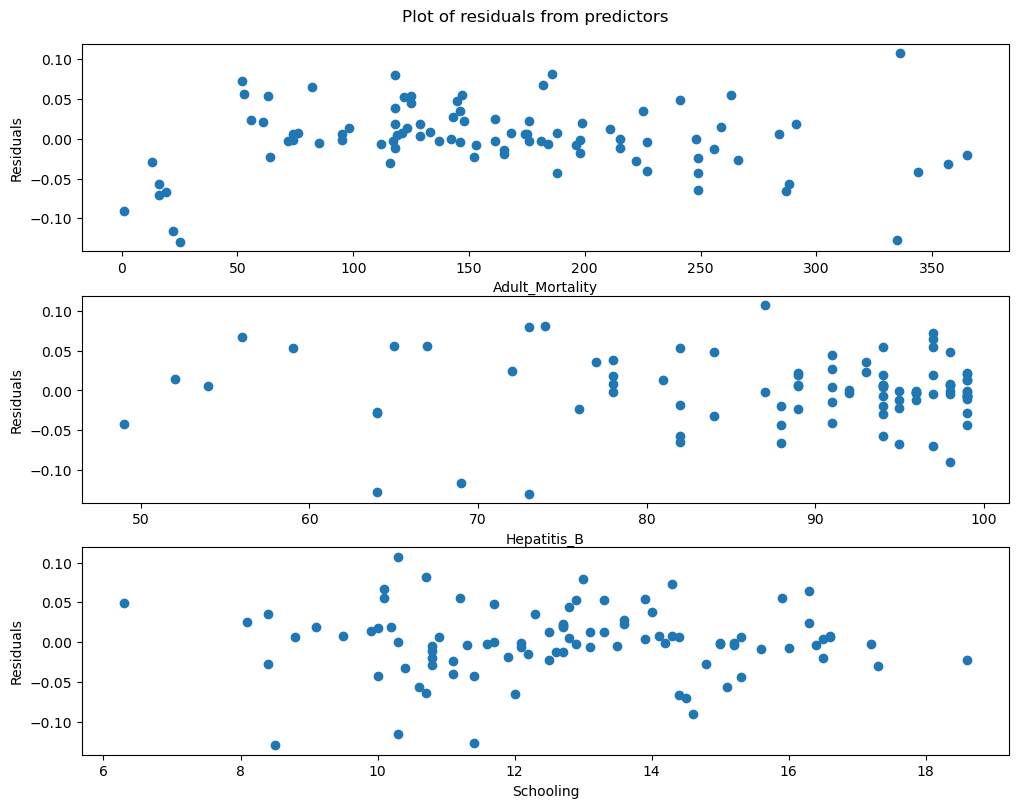

In [298]:
fig, axs = plt.subplots(figsize=(10, 8), nrows= 3 , ncols= 1 )

#add title
fig.suptitle('Plot of residuals from predictors')
fig.tight_layout()
#add data to plots
axs[0].scatter(data['Adult_Mortality'], log_model2.resid)
axs[0].set_xlabel('Adult_Mortality')
axs[1].scatter(data['Hepatitis_B'], log_model2.resid)
axs[1].set_xlabel('Hepatitis_B')
axs[2].scatter(data['Schooling'], log_model2.resid)
axs[2].set_xlabel('Schooling')
for i in range(3):
    axs[i].set_ylabel('Residuals')

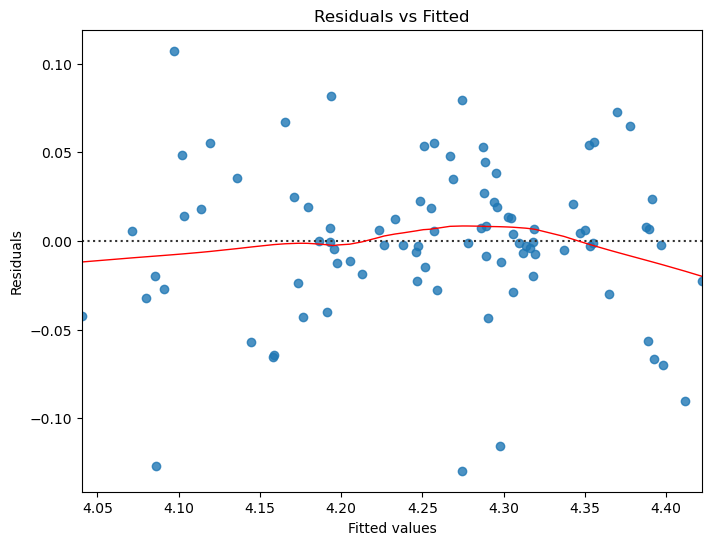

In [299]:
plt.figure(figsize=(8, 6))
sns.residplot(x=log_model2.fittedvalues, y=log_model2.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

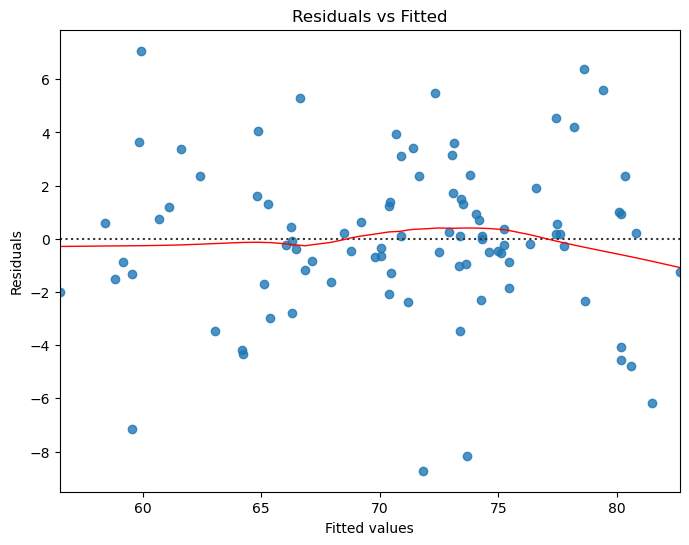

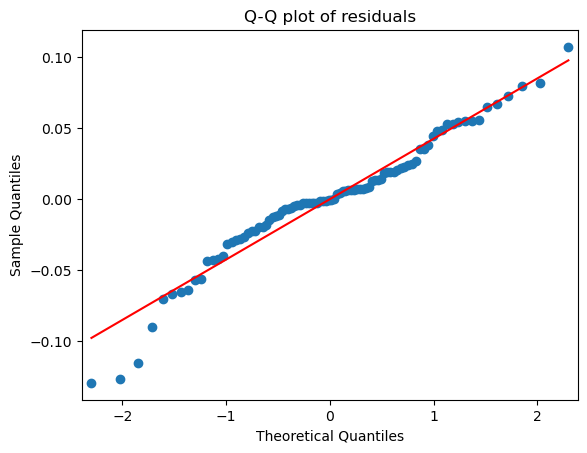

In [300]:
# Анализ ошибок модели
plt.figure(figsize=(8, 6))
sns.residplot(x=model2.fittedvalues, y=model2.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Q-Q plot для проверки нормальности остатков
sm.qqplot(log_model2.resid, line='s')
plt.title('Q-Q plot of residuals')
plt.show()

In [309]:
X = np.array(data[['Adult_Mortality', 'Hepatitis_B', 'BMI', 'GDP', 'Schooling']])
Y = np.array(data['Life_expectancy'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
ridge_cv.fit(X_train, Y_train)
ridge_cv_pred = ridge_cv.predict(X_test)
ridge_cv_mse = mean_squared_error(Y_test, ridge_cv_pred)
ridge_cv_r2 = r2_score(Y_test, ridge_cv_pred)
ridge_cv

print('RidgeCV MSE:', ridge_cv_mse, 'R2:', ridge_cv_r2)

RidgeCV MSE: 16.260209135565677 R2: 0.6498967871301833


In [310]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)
lasso_cv.fit(X_train, Y_train)
lasso_cv_pred = lasso_cv.predict(X_test)
lasso_cv_mse = mean_squared_error(Y_test, lasso_cv_pred)
lasso_cv_r2 = r2_score(Y_test, lasso_cv_pred)


#print('White test statistics:\n', dict(zip(labels, het_white(lasso_cv.resid, lasso_cv.model.exog))))
print('LassoCV MSE:', lasso_cv_mse, 'R2:', lasso_cv_r2)

LassoCV MSE: 16.260210718274994 R2: 0.6498967530524163


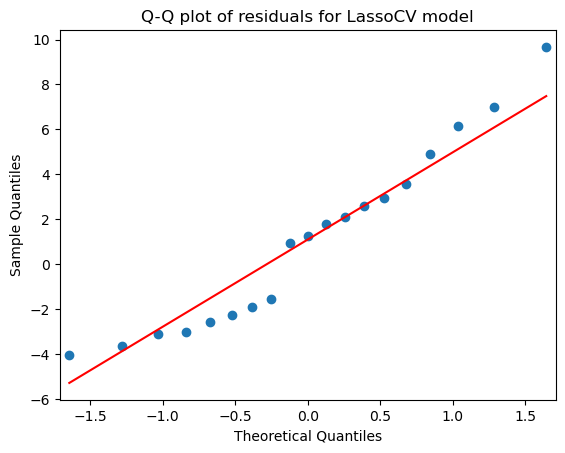

In [311]:
# Анализ ошибок модели LassoCV
residuals = Y_test - lasso_cv_pred
sm.qqplot(residuals, line='s')
plt.title('Q-Q plot of residuals for LassoCV model')
plt.show()

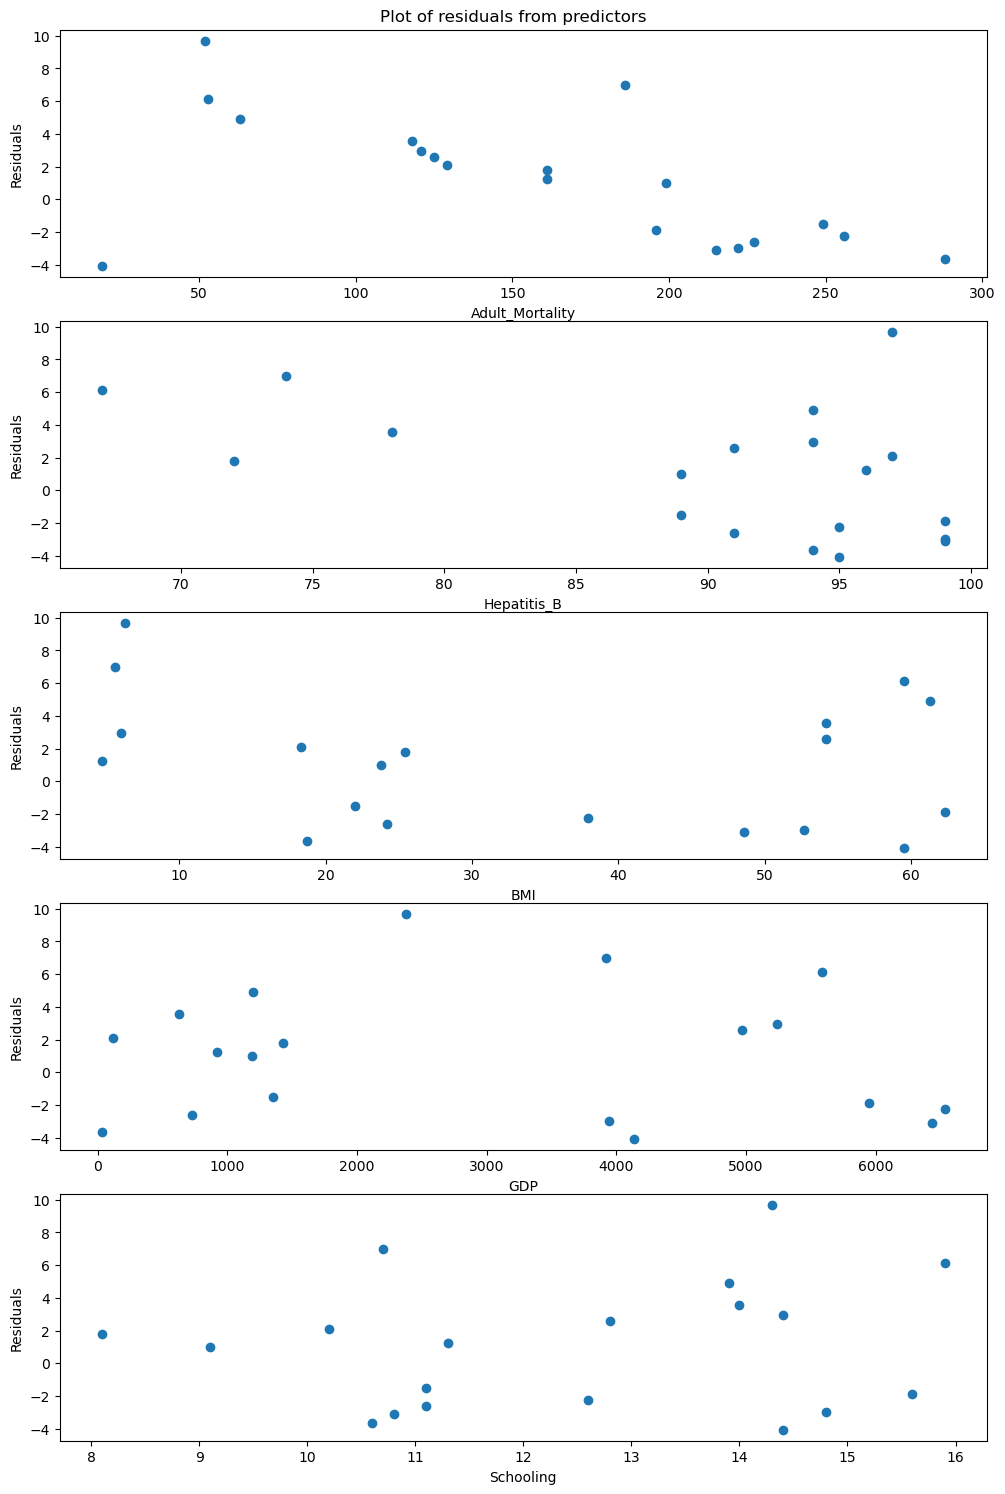

In [312]:
fig, axs = plt.subplots(figsize=(10, 15), nrows= 5 , ncols= 1 )

#add title
fig.suptitle('Plot of residuals from predictors')
fig.tight_layout()
#add data to plots
for i in range(5):
    x = X_test[:, i]
    axs[i].set_ylabel('Residuals')
    axs[i].scatter(x, Y_test - lasso_cv_pred)
    axs[i].set_xlabel(data.columns[i+2])